In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys

sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
# RAW_DATA_PATH1 = "../datasets/fraud/fraudTrain.csv"
# RAW_DATA_PATH2 = "../datasets/fraud/fraudTest.csv"
SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_2.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data1 = pd.read_csv("../datasets/fraud/fraudTrain.csv", index_col='Unnamed: 0')
# raw_data2 = pd.read_csv("../datasets/fraud/fraudTest.csv", index_col='Unnamed: 0')
# raw_data = pd.concat([raw_data1, raw_data2])
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.055, random_state=42, stratify=raw_data["is_fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH, index_col='Unnamed: 0')
print(df.shape[0])
df["is_fraud"].value_counts()/df.shape[0]*100

101882


is_fraud
0    99.478809
1     0.521191
Name: count, dtype: float64

In [3]:
df.isna().any()

trans_date_trans_time    False
cc_num                   False
merchant                 False
category                 False
amt                      False
first                    False
last                     False
gender                   False
street                   False
city                     False
state                    False
zip                      False
lat                      False
long                     False
city_pop                 False
job                      False
dob                      False
trans_num                False
unix_time                False
merch_lat                False
merch_long               False
is_fraud                 False
dtype: bool

In [4]:
numerical_columns = df.select_dtypes(
        include='number').columns.to_list()
numerical_columns

['cc_num',
 'amt',
 'zip',
 'lat',
 'long',
 'city_pop',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [5]:
pd.set_option('display.max_columns', None)

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
81955,2019-02-18 05:13:53,30442439074871,fraud_Prohaska-Murray,gas_transport,84.50,Linda,Sanchez,F,6574 William Hill Apt. 375,Jermyn,PA,18433,41.5744,-75.5881,6508,Training and development officer,1981-06-22,e87d0600784494b1fa22cc39ee43a664,1329542033,41.415102,-74.742120,0
105389,2020-07-27 21:39:15,4599735407877245080,fraud_Crona and Sons,kids_pets,141.70,Mary,Myers,F,39787 Pamela Fall Suite 639,Tiptonville,TN,38079,36.3846,-89.4649,5577,Geochemist,1964-12-30,aa521d71ed29b262ed53702992785426,1374961155,35.532554,-89.097033,0
442525,2020-12-07 04:50:50,375848982312810,fraud_Erdman-Kertzmann,gas_transport,92.17,Dale,Smith,M,25036 Contreras Turnpike Suite 270,Purmela,TX,76566,31.4841,-97.9903,258,Web designer,1943-12-15,ebdbe410178c5365013842e9555aac59,1386391850,30.521008,-97.837087,0
916621,2019-12-30 03:31:10,375237305371366,fraud_Sawayn PLC,shopping_pos,9.89,David,Erickson,M,616 Jimenez Meadow Apt. 701,East Rochester,NY,14445,43.1128,-77.4906,8019,Retail buyer,1928-06-26,ff86e07988b326802e76ef0db08dc994,1356838270,42.571261,-78.185175,0
117618,2019-03-07 18:03:51,4607072969078276,fraud_Abbott-Steuber,personal_care,13.98,Brenda,Perez,F,033 Tara Brook Suite 523,Coyle,OK,73027,35.8985,-97.2607,1493,Amenity horticulturist,1985-03-21,bff6baa0a339d57d105bd587012d35a9,1331143431,36.858453,-97.334306,0


In [6]:
df.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
import numpy as np

def preprocess_lat_lon(df:pd.DataFrame, lat_col_name:str="latitude", lon_col_name:str="longitude") -> pd.DataFrame:
    """
    Preprocesses latitude and longitude columns.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to preprocess.
    lat_col_name : str
        The name of the latitude column.
    lon_col_name : str
        The name of the longitude column.
        
    Returns
    -------
    pd.DataFrame
        The preprocessed dataframe.
    """
    # Convert to radians
    df[f"{lat_col_name}_x"] = np.cos(df[lat_col_name]) * np.cos(df[lon_col_name])
    df[f"{lon_col_name}_y"] = np.cos(df[lat_col_name]) * np.sin(df[lon_col_name])
    df[f"{lat_col_name}_z"] = np.sin(df[lat_col_name])
    return df.drop([lat_col_name, lon_col_name], axis=1)

In [8]:
y = "is_fraud"

# some generic cleaning
# Amt - amount of the transaction in local currency
# otherwise unrecognized cases in test set
counts = df.value_counts([y, "job"])
jobs_to_filter = counts[counts==1].reset_index()["job"].unique()
df = df.loc[~df.job.isin(jobs_to_filter)]

COLUMNS_TO_DROP = ["city", "trans_date_trans_time", "merchant", "first", "last", "street", "zip", "trans_num", "dob"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="lat", lon_col_name="long")
raw_features = raw_features.transform(preprocess_lat_lon, lat_col_name="merch_lat", lon_col_name="merch_long")

# ML tuning
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[[y, "job"]])

fit_le = LabelEncoder().fit(train[y])

In [9]:
pipeline = build_sklearn_pipeline(train, y, "logistic", LogisticRegression())
pipeline.fit(train.drop(y, axis=1), train[y])
print(Pipeline(pipeline.steps[:-1]).transform(train.drop(y, axis=1)).shape)
pipeline.predict(train.drop(y, axis=1))

(54081, 384)


array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [10]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [10, 20,30],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.9007803498161909
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 30, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', 'city_pop',
                                                   'unix_time', 'lat_x',
                                                   'long_y', 'lat_z',
                                                   'merch_lat_x',
                                                   'merch_long_y',
                                                   'merch_lat_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category', 'gender',
                                                   'state', 'job'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=30)),
                ('logistic', LogisticRegression(C=100))])

In [11]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [12]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,10,1,l2,0.849716,0.046910
108,0.1,0.2,10,10,l2,0.847056,0.046552
216,0.1,0.2,10,100,l2,0.846230,0.045421
324,0.1,0.2,10,1000,l2,0.846336,0.043516
6,0.1,0.2,20,1,l2,0.878998,0.030692
...,...,...,...,...,...,...,...
424,0.7,1.0,20,1000,l2,0.881892,0.027887
106,0.7,1.0,30,1,l2,0.885566,0.035248
214,0.7,1.0,30,10,l2,0.894996,0.030204
322,0.7,1.0,30,100,l2,0.893259,0.025868


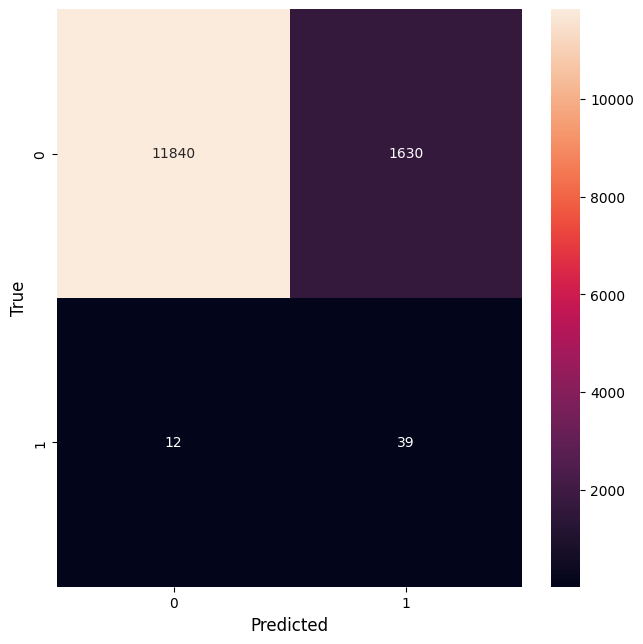

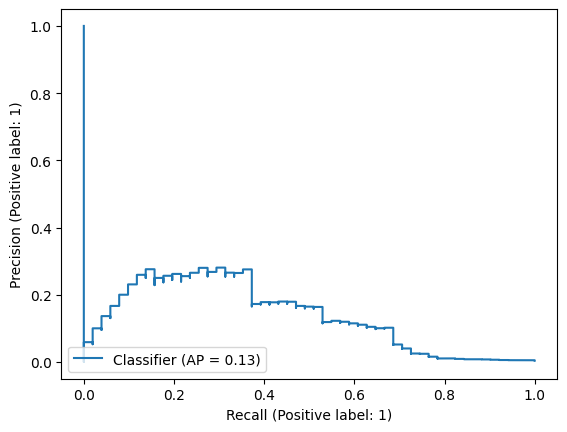

In [13]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name = 'logistic')

In [28]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.931907467581952
Best parameters: {'xgb__subsample': 1.0, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 3, 'xgb__gamma': 2, 'xgb__colsample_bytree': 1.0, 'under__sampling_strategy': 0.3, 'pca__n_components': 35, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', 'city_pop',
                                                   'unix_time', 'lat_x',
                                                   'long_y', 'lat_z',
                                                   'merch_lat_x',
                                                   'merch_long_y',
                                                   'merch_lat_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

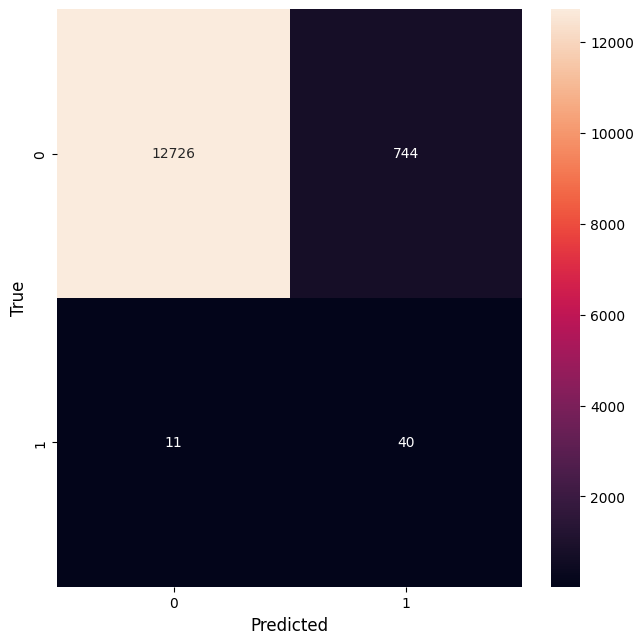

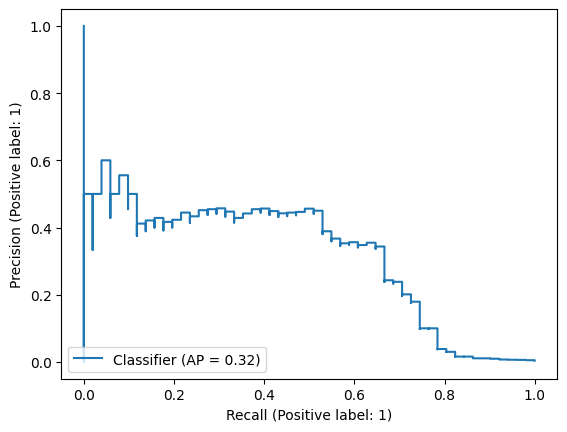

In [29]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [14]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [30]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["amt"]).to_frame())[:, 0]

# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")


Test cost/loss = 1861.


In [33]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["is_fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["amt"]).to_frame())[:, 0]

# Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['is_fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")

Test cost/loss = 966.


In [16]:


print(test_predictions[['is_fraud', "A", 'instance_cost', "y_predicted"]].head(30))

         is_fraud        A  instance_cost  y_predicted
377359          0    62.63            0.0            0
343471          0    67.01            0.0            0
858312          0    17.55            0.0            0
653694          0    32.14            0.0            0
485688          0    68.74            0.0            0
381035          0   120.01            0.0            0
513268          0    51.93            1.0            1
430783          0    77.72            0.0            0
345889          0    96.65            0.0            0
953633          0    46.46            0.0            0
280700          0     7.65            0.0            0
136120          0   177.49            1.0            1
52731           0   148.71            0.0            0
683053          0    40.72            0.0            0
1201668         0    74.64            0.0            0
1130978         0     6.05            0.0            0
156956          1  1194.56            1.0            1
264952    

# E-AMC metric

In [34]:


cb_column = 'cb'
test[cb_column]=(test["amt"])

test['TN'] = 0
test['FN'] = test['amt']
test['FP'] = 1
test['TP'] = 1

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)
test_predictions_xgb =  add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)


c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [18]:
test

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,cb,TN,FN,FP,TP,prob_churn,EAP,EP
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,62.63,0,62.63,1,1,0.155483,0.155483,0.005658
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,67.01,0,67.01,1,1,0.032481,0.032481,0.005658
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,17.55,0,17.55,1,1,0.293574,0.293574,0.005658
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,32.14,0,32.14,1,1,0.266750,0.266750,0.005658
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,68.74,0,68.74,1,1,0.244350,0.244350,0.005658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,19.34,0,19.34,1,1,0.219742,15.309939,19.236229
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1083.88,0,1083.88,1,1,0.995713,5.641944,1077.752871
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,544.79,0,544.79,1,1,0.901638,54.488067,541.713139
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,314.36,0,314.36,1,1,0.751330,78.923104,312.586953


In [35]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

5368.547938144426
26764.986728240972
EAP :  0.39705258029320506
EP :  1.979512368037939


In [37]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

2550.3624497438695
26764.986728240972
EAP :  0.188622324513266
EP :  1.979512368037939


# AMC metric

Decision Threshold: 0.01, Test cost/loss = 13166.00
Decision Threshold: 0.02, Test cost/loss = 12620.00
Decision Threshold: 0.03, Test cost/loss = 12162.00
Decision Threshold: 0.04, Test cost/loss = 11721.00
Decision Threshold: 0.05, Test cost/loss = 11284.00
Decision Threshold: 0.06, Test cost/loss = 10824.00
Decision Threshold: 0.07, Test cost/loss = 10374.00
Decision Threshold: 0.08, Test cost/loss = 9963.14
Decision Threshold: 0.09, Test cost/loss = 9520.14
Decision Threshold: 0.10, Test cost/loss = 9146.14
Decision Threshold: 0.11, Test cost/loss = 8775.14
Decision Threshold: 0.12, Test cost/loss = 8433.24
Decision Threshold: 0.13, Test cost/loss = 8087.24
Decision Threshold: 0.14, Test cost/loss = 7723.24
Decision Threshold: 0.15, Test cost/loss = 7386.24
Decision Threshold: 0.16, Test cost/loss = 7122.05
Decision Threshold: 0.17, Test cost/loss = 6858.05
Decision Threshold: 0.18, Test cost/loss = 6609.05
Decision Threshold: 0.19, Test cost/loss = 6385.05
Decision Threshold: 0.20

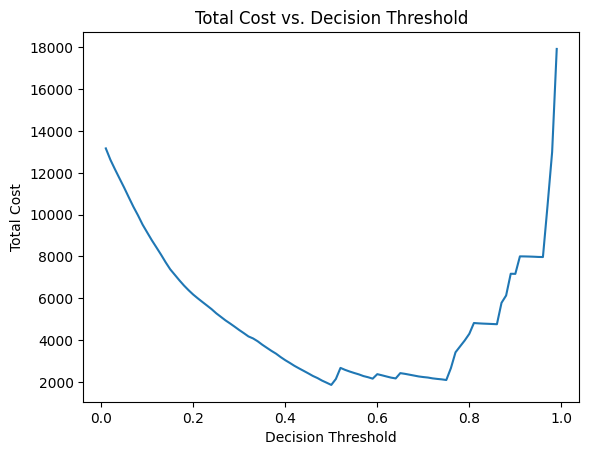

(0.5, 0.13765106131203314, 1861.18)

In [38]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')


Decision Threshold: 0.01, Test cost/loss = 10530.00
Decision Threshold: 0.02, Test cost/loss = 9040.34
Decision Threshold: 0.03, Test cost/loss = 8142.08
Decision Threshold: 0.04, Test cost/loss = 7406.18
Decision Threshold: 0.05, Test cost/loss = 6770.18
Decision Threshold: 0.06, Test cost/loss = 6254.18
Decision Threshold: 0.07, Test cost/loss = 5793.18
Decision Threshold: 0.08, Test cost/loss = 5377.18
Decision Threshold: 0.09, Test cost/loss = 5028.99
Decision Threshold: 0.10, Test cost/loss = 4711.99
Decision Threshold: 0.11, Test cost/loss = 4424.99
Decision Threshold: 0.12, Test cost/loss = 4205.73
Decision Threshold: 0.13, Test cost/loss = 3974.73
Decision Threshold: 0.14, Test cost/loss = 3761.73
Decision Threshold: 0.15, Test cost/loss = 3573.73
Decision Threshold: 0.16, Test cost/loss = 3375.73
Decision Threshold: 0.17, Test cost/loss = 3219.73
Decision Threshold: 0.18, Test cost/loss = 3059.73
Decision Threshold: 0.19, Test cost/loss = 2936.73
Decision Threshold: 0.20, Test

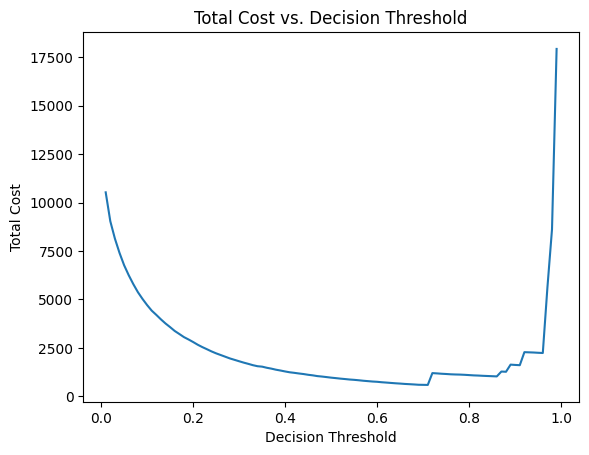

(0.7100000000000001, 0.043723097404038166, 591.1800000000001)

In [40]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')


# emp

In [42]:
cb_column = 'cb'
test[cb_column]=(test["amt"])

test['TN'] = 0
test['FN'] = -test['amt']
test['FP'] = -1
test['TP'] = -1 + test['amt']

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)

test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [22]:
test

,cc_num,category,amt,gender,state,city_pop,job,unix_time,is_fraud,lat_x,long_y,lat_z,merch_lat_x,merch_long_y,merch_lat_z,cb,TN,FN,FP,TP,prob_churn,EAP,EP,y_predicted_proba,instance_cost
377359,3540210836308425,food_dining,62.63,M,TX,53,Fisheries officer,1384536888,0,0.386883,0.903359,-0.185107,0.974763,0.171631,-0.142757,62.63,0,-62.63,-1,61.63,0.155483,-0.155483,-0.005658,0.155483,0.00
343471,639030014711,entertainment,67.01,M,IL,639,Mechanical engineer,1383260389,0,0.374299,-0.790767,-0.484343,-0.101118,-0.751755,-0.651644,67.01,0,-67.01,-1,66.01,0.032481,-0.032481,-0.005658,0.032481,0.00
858312,377264520876399,personal_care,17.55,F,SC,4424,Lawyer,1355689325,0,-0.370872,-0.903818,0.213464,-0.117634,-0.817296,-0.564083,17.55,0,-17.55,-1,16.55,0.293574,-0.293574,-0.005658,0.293574,0.00
653694,213157767990030,health_fitness,32.14,F,WY,27971,Music therapist,1349466301,0,0.539446,0.478639,-0.692750,-0.001038,-0.002552,-0.999996,32.14,0,-32.14,-1,31.14,0.266750,-0.266750,-0.005658,0.266750,0.00
485688,30408301059761,kids_pets,68.74,M,SC,4471,Occupational hygienist,1343748738,0,-0.025769,-0.341624,0.939483,0.190030,-0.354266,0.915633,68.74,0,-68.74,-1,67.74,0.244350,-0.244350,-0.005658,0.244350,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202685,374821819075109,health_fitness,19.34,M,NY,9565,Exhibition designer,1368835137,1,-0.151494,-0.586493,-0.795660,0.420107,-0.862442,-0.282320,19.34,0,-19.34,-1,18.34,0.219742,-11.060136,-19.126800,0.219742,19.34
670176,4266200684857219,shopping_net,1083.88,M,NE,732,Television/film/video producer,1350086058,1,0.624315,-0.503856,0.596958,0.691758,0.004403,0.722116,1083.88,0,-1083.88,-1,1082.88,0.995713,1073.591826,-1071.620083,0.995713,1.00
1131211,4810789809665942990,entertainment,544.79,F,OH,338,Quantity surveyor,1366066429,1,0.134441,0.269255,0.953639,-0.021650,0.099756,0.994776,544.79,0,-544.79,-1,543.79,0.901638,436.715505,-538.630619,0.901638,544.79
90178,4195740185974,grocery_pos,314.36,M,OR,841711,"Engineer, building services",1374463871,1,-0.022418,0.004107,0.999740,-0.325970,-0.031024,0.944871,314.36,0,-314.36,-1,313.36,0.751330,157.265123,-310.808248,0.751330,314.36


In [43]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

19332.44293367664
-26613.119212847392
EAP :  1.429808663092718
EP :  -1.9682803944122027


In [44]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test))

23440.491196203708
-26613.119212847392
EAP :  1.733635914222595
EP :  -1.9682803944122027


# MP

In [45]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1 -a
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a

Decision Threshold: 0.01, Test cost/loss = -13674.35
Decision Threshold: 0.02, Test cost/loss = -14220.35
Decision Threshold: 0.03, Test cost/loss = -14678.35
Decision Threshold: 0.04, Test cost/loss = -15119.35
Decision Threshold: 0.05, Test cost/loss = -15556.35
Decision Threshold: 0.06, Test cost/loss = -16016.35
Decision Threshold: 0.07, Test cost/loss = -16466.35
Decision Threshold: 0.08, Test cost/loss = -16868.07
Decision Threshold: 0.09, Test cost/loss = -17302.07
Decision Threshold: 0.10, Test cost/loss = -17662.07
Decision Threshold: 0.11, Test cost/loss = -18033.07
Decision Threshold: 0.12, Test cost/loss = -18352.87
Decision Threshold: 0.13, Test cost/loss = -18698.87
Decision Threshold: 0.14, Test cost/loss = -19062.87
Decision Threshold: 0.15, Test cost/loss = -19399.87
Decision Threshold: 0.16, Test cost/loss = -19644.25
Decision Threshold: 0.17, Test cost/loss = -19908.25
Decision Threshold: 0.18, Test cost/loss = -20157.25
Decision Threshold: 0.19, Test cost/loss = -20

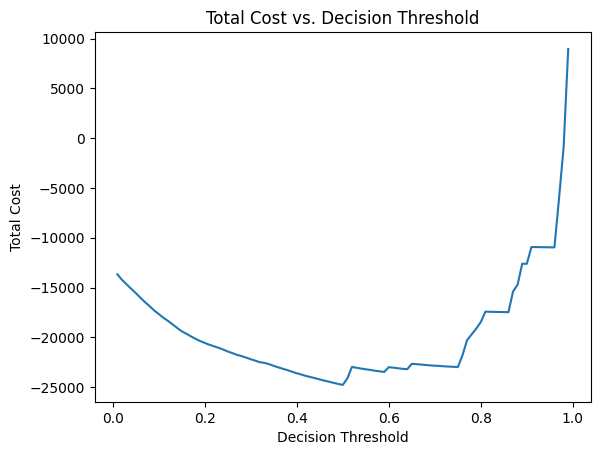

(0.5, -1.8332216552030176, -24786.99)

In [46]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')


Decision Threshold: 0.01, Test cost/loss = -16310.35
Decision Threshold: 0.02, Test cost/loss = -17780.67
Decision Threshold: 0.03, Test cost/loss = -18659.19
Decision Threshold: 0.04, Test cost/loss = -19372.99
Decision Threshold: 0.05, Test cost/loss = -19999.99
Decision Threshold: 0.06, Test cost/loss = -20515.99
Decision Threshold: 0.07, Test cost/loss = -20976.99
Decision Threshold: 0.08, Test cost/loss = -21392.99
Decision Threshold: 0.09, Test cost/loss = -21721.37
Decision Threshold: 0.10, Test cost/loss = -22038.37
Decision Threshold: 0.11, Test cost/loss = -22325.37
Decision Threshold: 0.12, Test cost/loss = -22516.89
Decision Threshold: 0.13, Test cost/loss = -22747.89
Decision Threshold: 0.14, Test cost/loss = -22960.89
Decision Threshold: 0.15, Test cost/loss = -23148.89
Decision Threshold: 0.16, Test cost/loss = -23346.89
Decision Threshold: 0.17, Test cost/loss = -23502.89
Decision Threshold: 0.18, Test cost/loss = -23662.89
Decision Threshold: 0.19, Test cost/loss = -23

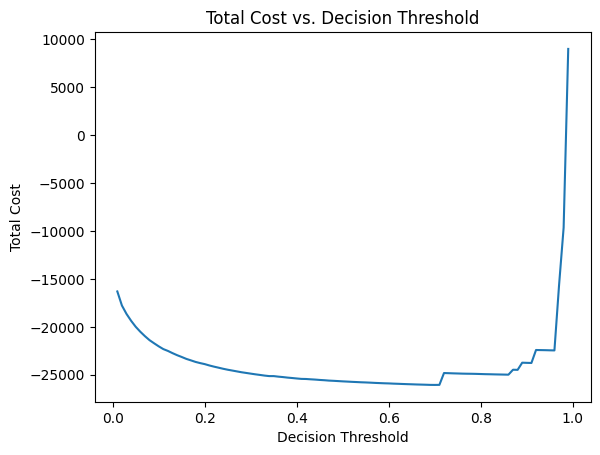

(0.7000000000000001, -1.927565268841062, -26062.61)

In [47]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')